<ol style="list-style-type: none; padding: 0;">

  <!-- Problem Formulation for Movie Recommendation using Reinforcement Learning -->

  <!-- 1. Define the State Space -->
  <li style="margin-bottom: 20px; padding: 15px; background-color: #2c3e50; border-radius: 8px; box-shadow: 0 4px 8px rgba(255, 255, 255, 0.1);">
    <span style="font-weight: bold; font-size: 1.2em; color: #3498db;">1. State Space:</span>
    <p style="margin-left: 20px; color: #ecf0f1;">Encompassing the entirety of potential user and movie interactions, articulated through a synthesis of user preferences, movie features, and historical behavior.</p>
  </li>

  <!-- 2. Define the Action Space -->
  <li style="margin-bottom: 20px; padding: 15px; background-color: #2c3e50; border-radius: 8px; box-shadow: 0 4px 8px rgba(255, 255, 255, 0.1);">
    <span style="font-weight: bold; font-size: 1.2em; color: #e74c3c;">2. Action Space:</span>
    <p style="margin-left: 20px; color: #ecf0f1;">Comprising the repertoire of viable actions the system can undertake, including the discernment and recommendation of movies from the comprehensive database.</p>
  </li>

  <!-- 3. Define the Reward Function -->
  <li style="margin-bottom: 20px; padding: 15px; background-color: #2c3e50; border-radius: 8px; box-shadow: 0 4px 8px rgba(255, 255, 255, 0.1);">
    <span style="font-weight: bold; font-size: 1.2em; color: #2ecc71;">3. Reward Function:</span>
    <p style="margin-left: 20px; color: #ecf0f1;">A discerning function quantifying the merit of a movie recommendation, contingent upon user feedback, ratings, or overall engagement.</p>
  </li>

  <!-- 4. Define the Transition Model -->
  <li style="margin-bottom: 20px; padding: 15px; background-color: #2c3e50; border-radius: 8px; box-shadow: 0 4px 8px rgba(255, 255, 255, 0.1);">
    <span style="font-weight: bold; font-size: 1.2em; color: #f39c12;">4. Transition Model:</span>
    <p style="margin-left: 20px; color: #ecf0f1;">Elucidating the mechanisms by which the system progresses from one state to another, contingent upon user responses to the rendered recommendations.</p>
  </li>

  <!-- 5. Define the Policy -->
  <li style="margin-bottom: 20px; padding: 15px; background-color: #2c3e50; border-radius: 8px; box-shadow: 0 4px 8px rgba(255, 255, 255, 0.1);">
    <span style="font-weight: bold; font-size: 1.2em; color: #9b59b6;">5. Policy:</span>
    <p style="margin-left: 20px; color: #ecf0f1;">The strategic algorithm dictating the formulation of movie recommendations based on the current state of the interaction.</p>
  </li>

  <!-- 6. Define the Exploration-Exploitation Tradeoff -->
  <li style="margin-bottom: 20px; padding: 15px; background-color: #2c3e50; border-radius: 8px; box-shadow: 0 4px 8px rgba(255, 255, 255, 0.1);">
    <span style="font-weight: bold; font-size: 1.2em; color: #3498db;">6. Exploration-Exploitation Tradeoff:</span>
    <p style="margin-left: 20px; color: #ecf0f1;">Striking a delicate balance between the exploration of novel movie choices to glean user preferences and the exploitation of known preferences to furnish refined recommendations.</p>
  </li>

  <!-- 7. Define the Termination Condition -->
  <li style="margin-bottom: 20px; padding: 15px; background-color: #2c3e50; border-radius: 8px; box-shadow: 0 4px 8px rgba(255, 255, 255, 0.1);">
    <span style="font-weight: bold; font-size: 1.2em; color: #e74c3c;">7. Termination Condition:</span>
    <p style="margin-left: 20px; color: #ecf0f1;">Establishing the criteria governing the conclusion of the recommendation process, whether through a maximum number of recommendations or a predetermined user satisfaction threshold.</p>
  </li>

</ol>

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=True)` instead.


13

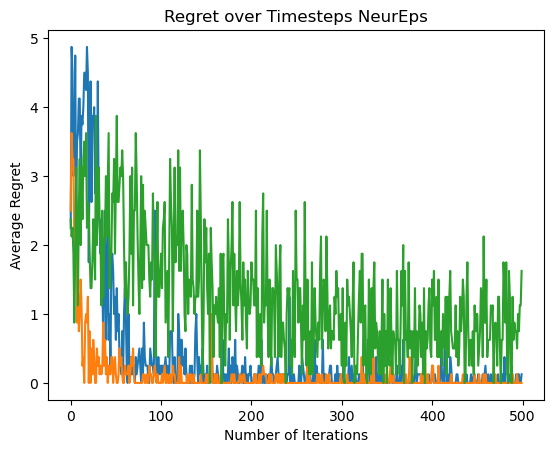

In [1]:
import tensorflow as tf
import tf_agents
from tf_agents.bandits.environments import movielens_py_environment
from tf_agents.environments import tf_py_environment
from tf_agents.bandits.environments import environment_utilities
from tf_agents.bandits.metrics import tf_metrics as tf_bandit_metrics
from tf_agents.bandits.agents import lin_ucb_agent
from tf_agents.bandits.agents import linear_thompson_sampling_agent as lin_ts_agent
from tf_agents.networks import q_network
from tf_agents.bandits.agents import neural_epsilon_greedy_agent as eps_greedy_agent
from tf_agents.bandits.agents.examples.v2 import trainer
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.drivers import driver
from tf_agents.drivers import dynamic_step_driver
from tf_agents.policies import random_tf_policy
import functools
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt

BATCH_SIZE = 8
TRAINING_LOOPS = 500
STEPS_PER_LOOP = 2
RANK_K = 20
NUM_ACTIONS = 20

data_path = 'u.data'

env = movielens_py_environment.MovieLensPyEnvironment(
        data_path,
        RANK_K,
        BATCH_SIZE,
        num_movies=NUM_ACTIONS,
        csv_delimiter='\t')
environment = tf_py_environment.TFPyEnvironment(env)

optimal_reward_fn = functools.partial(
      environment_utilities.compute_optimal_reward_with_movielens_environment,
      environment=environment)

optimal_action_fn = functools.partial(
      environment_utilities.compute_optimal_action_with_movielens_environment,
      environment=environment)
AGENT_ALPHA = 10.0
linucb = lin_ucb_agent.LinearUCBAgent(
        time_step_spec=environment.time_step_spec(),
        action_spec=environment.action_spec(),
        tikhonov_weight=0.001,
        alpha=AGENT_ALPHA,
        dtype=tf.float32,
        accepts_per_arm_features=False)

lints = lin_ts_agent.LinearThompsonSamplingAgent(
        time_step_spec=environment.time_step_spec(),
        action_spec=environment.action_spec(),
        dtype=tf.float32,
        accepts_per_arm_features=False)
EPSILON = 0.05
LAYERS = (50, 50, 50)
LR = 0.005

network = q_network.QNetwork(
          input_tensor_spec=environment.time_step_spec().observation,
          action_spec=environment.action_spec(),
          fc_layer_params=LAYERS)

neureps = eps_greedy_agent.NeuralEpsilonGreedyAgent(
        time_step_spec=environment.time_step_spec(),
        action_spec=environment.action_spec(),
        reward_network=network,
        optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=LR),
        epsilon=EPSILON,
        emit_policy_info='predicted_rewards_mean',
        info_fields_to_inherit_from_greedy=['predicted_rewards_mean'])

regret_metric = tf_bandit_metrics.RegretMetric(optimal_reward_fn)
suboptimal_arms_metric = tf_bandit_metrics.SuboptimalArmsMetric(optimal_action_fn)

def train(agent):
    if agent == 'LinUCB':
        agent = linucb
    elif agent == 'LinTS':
        agent = lints
    elif agent == 'NeurEps':
        agent = neureps

    replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
        data_spec=agent.policy.trajectory_spec,
        batch_size=BATCH_SIZE,
        max_length=STEPS_PER_LOOP
    )

    observers = [replay_buffer.add_batch, regret_metric]

    driver = dynamic_step_driver.DynamicStepDriver(
        env=environment,
        policy=agent.collect_policy,
        num_steps=STEPS_PER_LOOP * BATCH_SIZE,
        observers=observers
    )

    regret_values = []

    for _ in range(TRAINING_LOOPS):
        driver.run()
        loss_info = agent.train(replay_buffer.gather_all())
        replay_buffer.clear()
        regret_values.append(regret_metric.result())

    return regret_values, agent

regret_values_linucb, linucb_agent = train('LinUCB')
plt.plot(regret_values_linucb)
plt.title('Regret over Timesteps LinUCB')
plt.xlabel('Number of Iterations')
plt.ylabel('Average Regret')

sum(regret_values_linucb)
regret_values_lints, lints_agent = train('LinTS')
plt.plot(regret_values_lints)
plt.title('Regret over Timesteps LinTS')
plt.xlabel('Number of Iterations')
plt.ylabel('Average Regret')

sum(regret_values_lints)
regret_values_neureps, neureps_agent = train('NeurEps')
plt.plot(regret_values_neureps)
plt.title('Regret over Timesteps NeurEps')
plt.xlabel('Number of Iterations')
plt.ylabel('Average Regret')

sum(regret_values_neureps)
def recommend_movies(agent, observation):
    time_step = tf_agents.trajectories.time_step.TimeStep(
        step_type=tf.constant([[2]], dtype=tf.int32),
        reward=tf.constant([[0.0]], dtype=tf.float32),
        discount=tf.constant([[1.0]], dtype=tf.float32),
        observation=observation)

    action_step = agent.policy.action(time_step)
    return action_step.action.numpy()[0]

observation = np.array([1, 25, 35, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1])
observation = np.expand_dims(observation, axis=0)
recommend_movies(lints_agent, observation=observation)

In [3]:
def recommend_movies(agent, observation):
    time_step = tf_agents.trajectories.time_step.TimeStep(
        step_type=tf.constant([[2]], dtype=tf.int32),
        reward=tf.constant([[0.0]], dtype=tf.float32),
        discount=tf.constant([[1.0]], dtype=tf.float32),
        observation=observation)

    action_step = agent.policy.action(time_step)
    return action_step.action.numpy()[0]

# Example observation
observation = np.array([1, 25, 35, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1])
observation = np.expand_dims(observation, axis=0)

# Get recommended movies
recommended_movies = recommend_movies(lints_agent, observation=observation)
print("Recommended Movies:", recommended_movies)

Recommended Movies: 13


<div style="background-color: #f0f8ff; padding: 15px; border-radius: 10px;">

# Recommendation Policy Overview

The recommendation policy serves as a pivotal element within a system designed to offer personalized movie suggestions, leveraging user interactions. Here's an overview of the recommendation policy:

## Input
- The policy takes a user vector (observation) as its input.

## Decision-Making Process
- The recommendation policy operates within the context of an agent.
- Decision-making is orchestrated by the agent's underlying model and strategic approach.

## Analysis Factors
- The agent scrutinizes the user vector, considering a myriad of factors.
- Key components in this analytical process include historical data and user preferences.

## Output
- The outcome is a collection of recommended movies generated by the policy.
- This output reflects personalized suggestions based on the distinctive characteristics and interactions of the given user within the system.

</div>
